# Modelo que evalúa las predicciones de progresión de la enfermedad en los datos de diabetes

Este cuaderno muestra el uso de la API 'responsibleai' para evaluar una regresión entrenada con datos de progresión de la diabetes. Explica las llamadas a la API necesarias para crear un widget con información de análisis del modelo y, a continuación, guía un análisis visual del modelo.

* [Ejecución de  Responsible AI Toolbox](#Ejecución-de-Responsible-AI-Toolbox)
    * [Entrenar un modelo](#Modelo-de-entrenamiento)
    * [Crear información sobre modelos y datos](#Crear-modelo-sobre-información-y-datos)
* [Evalúe su modelo](#Evalúe-su-modelo)
    * [Análisis agregado](#Análisis-agregados)
    * [Análisis individual](#Análisis-Individual)

## Ejecución de Responsible AI Toolbox

En la  siguiente sección se examina el código necesario para crear conjuntos de datos y un modelo. A continuación, genera información utilizando la API `responsibleai` que se puede analizar visualmente.

### Modelo de entrenamiento
*La siguiente sección se puede omitir. Carga un conjunto de datos y entrena un modelo con fines ilustrativos.*

In [ ]:
import shap
import sklearn
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

En primer lugar, cargue el conjunto de datos de diabetes y especifique los diferentes tipos de características. A continuación, límpialo y colócalo en un DataFrame con columnas con nombre.

In [ ]:
data = sklearn.datasets.load_diabetes()
target_feature = 'y'
continuous_features = data.feature_names
data_df = pd.DataFrame(data.data, columns=data.feature_names)

Después de cargar y limpiar los datos, divida los puntos de datos en conjuntos de entrenamiento y prueba. Reúna conjuntos de datos independientes para la muestra completa y los datos de prueba.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_df, data.target, test_size=0.2, random_state=7)

train_data = X_train.copy()
test_data = X_test.copy()
train_data[target_feature] = y_train
test_data[target_feature] = y_test
data.feature_names

Entrena un clasificador de vecinos más cercanos en los datos de entrenamiento.

In [ ]:
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

### Crear modelo sobre información y datos

In [ ]:
from raiwidgets import ResponsibleAIDashboard
from responsibleai import RAIInsights

Para utilizar Responsible AI Toolbox, inicialice un objeto RAIInsights en el que se puedan cargar diferentes componentes.

RAIInsights acepta el modelo, el conjunto de datos completo, el conjunto de datos de prueba, la cadena de características de destino y la cadena de tipo de tarea como argumentos.

También puede crear el contenedor `FeatureMetadata`, identificar cualquier característica de su elección como  `identity_feature`, especificar una lista de cadenas de nombres de características categóricas a través del parámetro `categorical_features` y especificar las características eliminadas a través del parámetro `dropped_features`. Los `FeatureMetadata`' también se pueden pasar a `RAIInsights`.

In [ ]:
from responsibleai.feature_metadata import FeatureMetadata
feature_metadata = FeatureMetadata(categorical_features=[], dropped_features=[])


In [ ]:
rai_insights = RAIInsights(model, train_data, test_data, target_feature, 'regression',
                               feature_metadata=feature_metadata)

Agregue los componentes de la caja de herramientas que se centran en la evaluación del modelo.

In [ ]:
# Interpretability
rai_insights.explainer.add()
# Error Analysis
rai_insights.error_analysis.add()
# Counterfactuals: accepts total number of counterfactuals to generate, the range that their label should fall under, 
# and a list of strings of categorical feature names
rai_insights.counterfactual.add(total_CFs=20, desired_range=[50, 120])

Una vez que se hayan cargado todos los componentes deseados, calcule la información en el conjunto de pruebas.

In [ ]:
rai_insights.compute()

Por último, visualice y explore la información del modelo. Utilice el widget resultante o siga el enlace para verlo en una nueva pestaña.

In [ ]:
ResponsibleAIDashboard(rai_insights)

## Evalúe su modelo

### Análisis agregados

Al abrir el widget del panel de control, el componente Análisis de errores se muestra en la parte superior. La vista de mapa de árbol de este componente visualiza el desglose de la cohorte del error en los nodos.

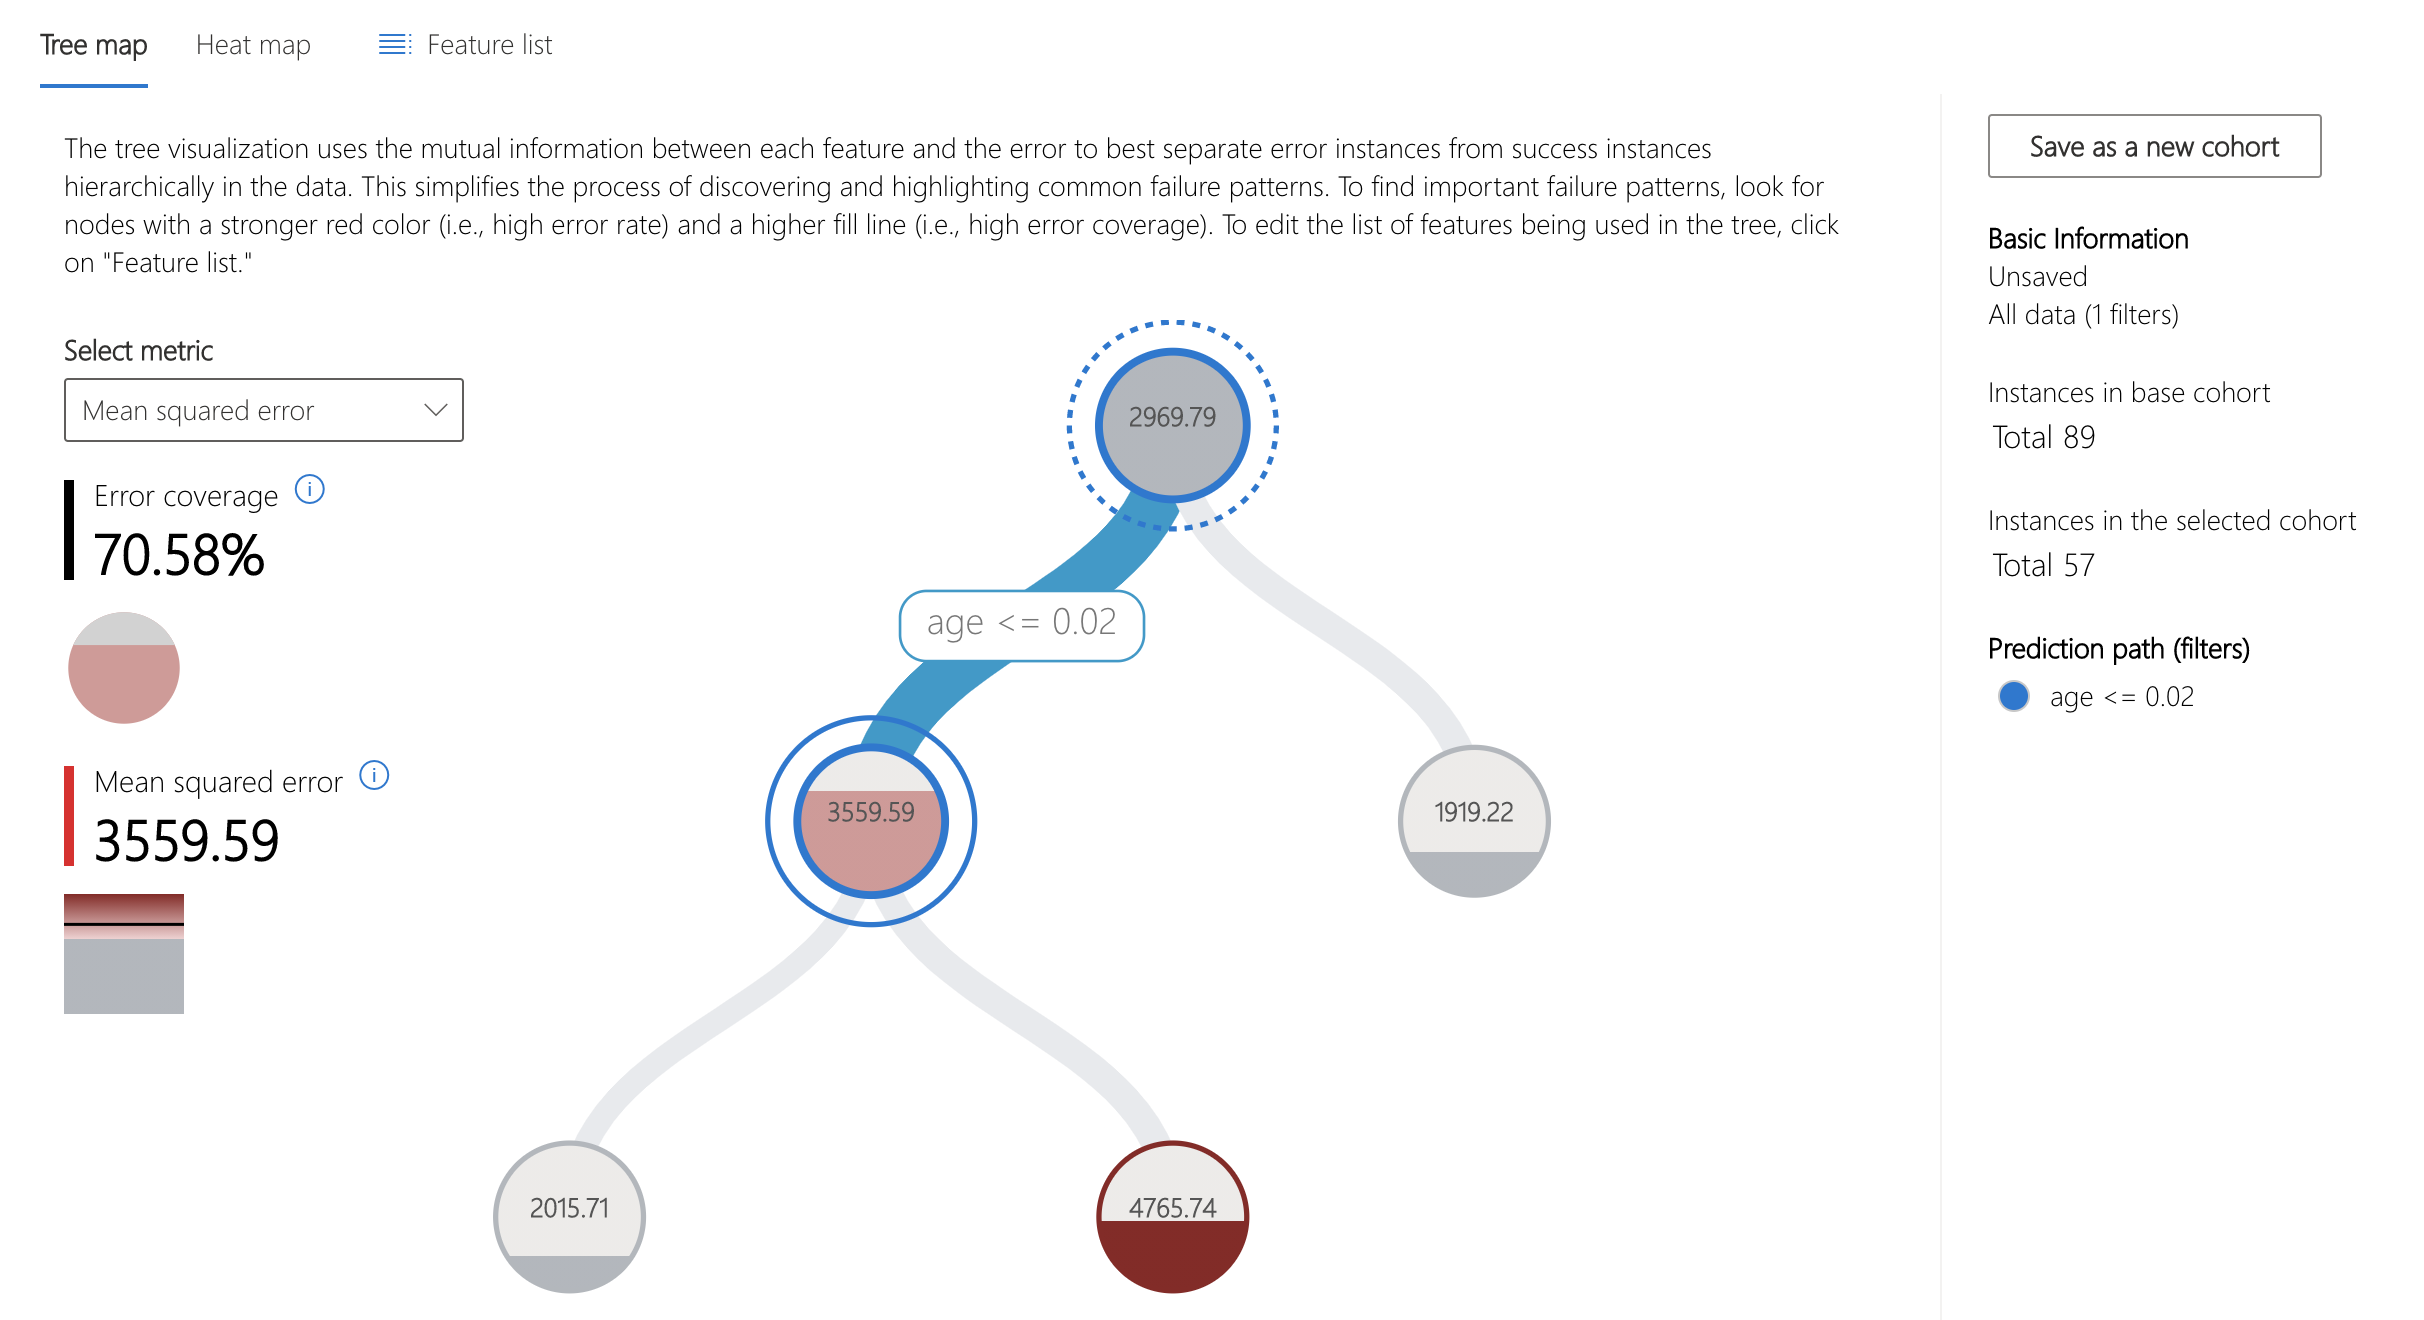

Para este modelo, más del 70% del error se concentra en puntos de datos cuya característica de antigüedad es inferior a 0,02. Tenga en cuenta que este valor se ha centrado en la media y se ha escalado por el número de muestras * desviación estándar.

Exploremos más a fondo esta cohorte.

En primer lugar, guarde la cohorte de interés. Esto se puede hacer haciendo clic en "Save as a new cohort" en el panel lateral de la atracción.

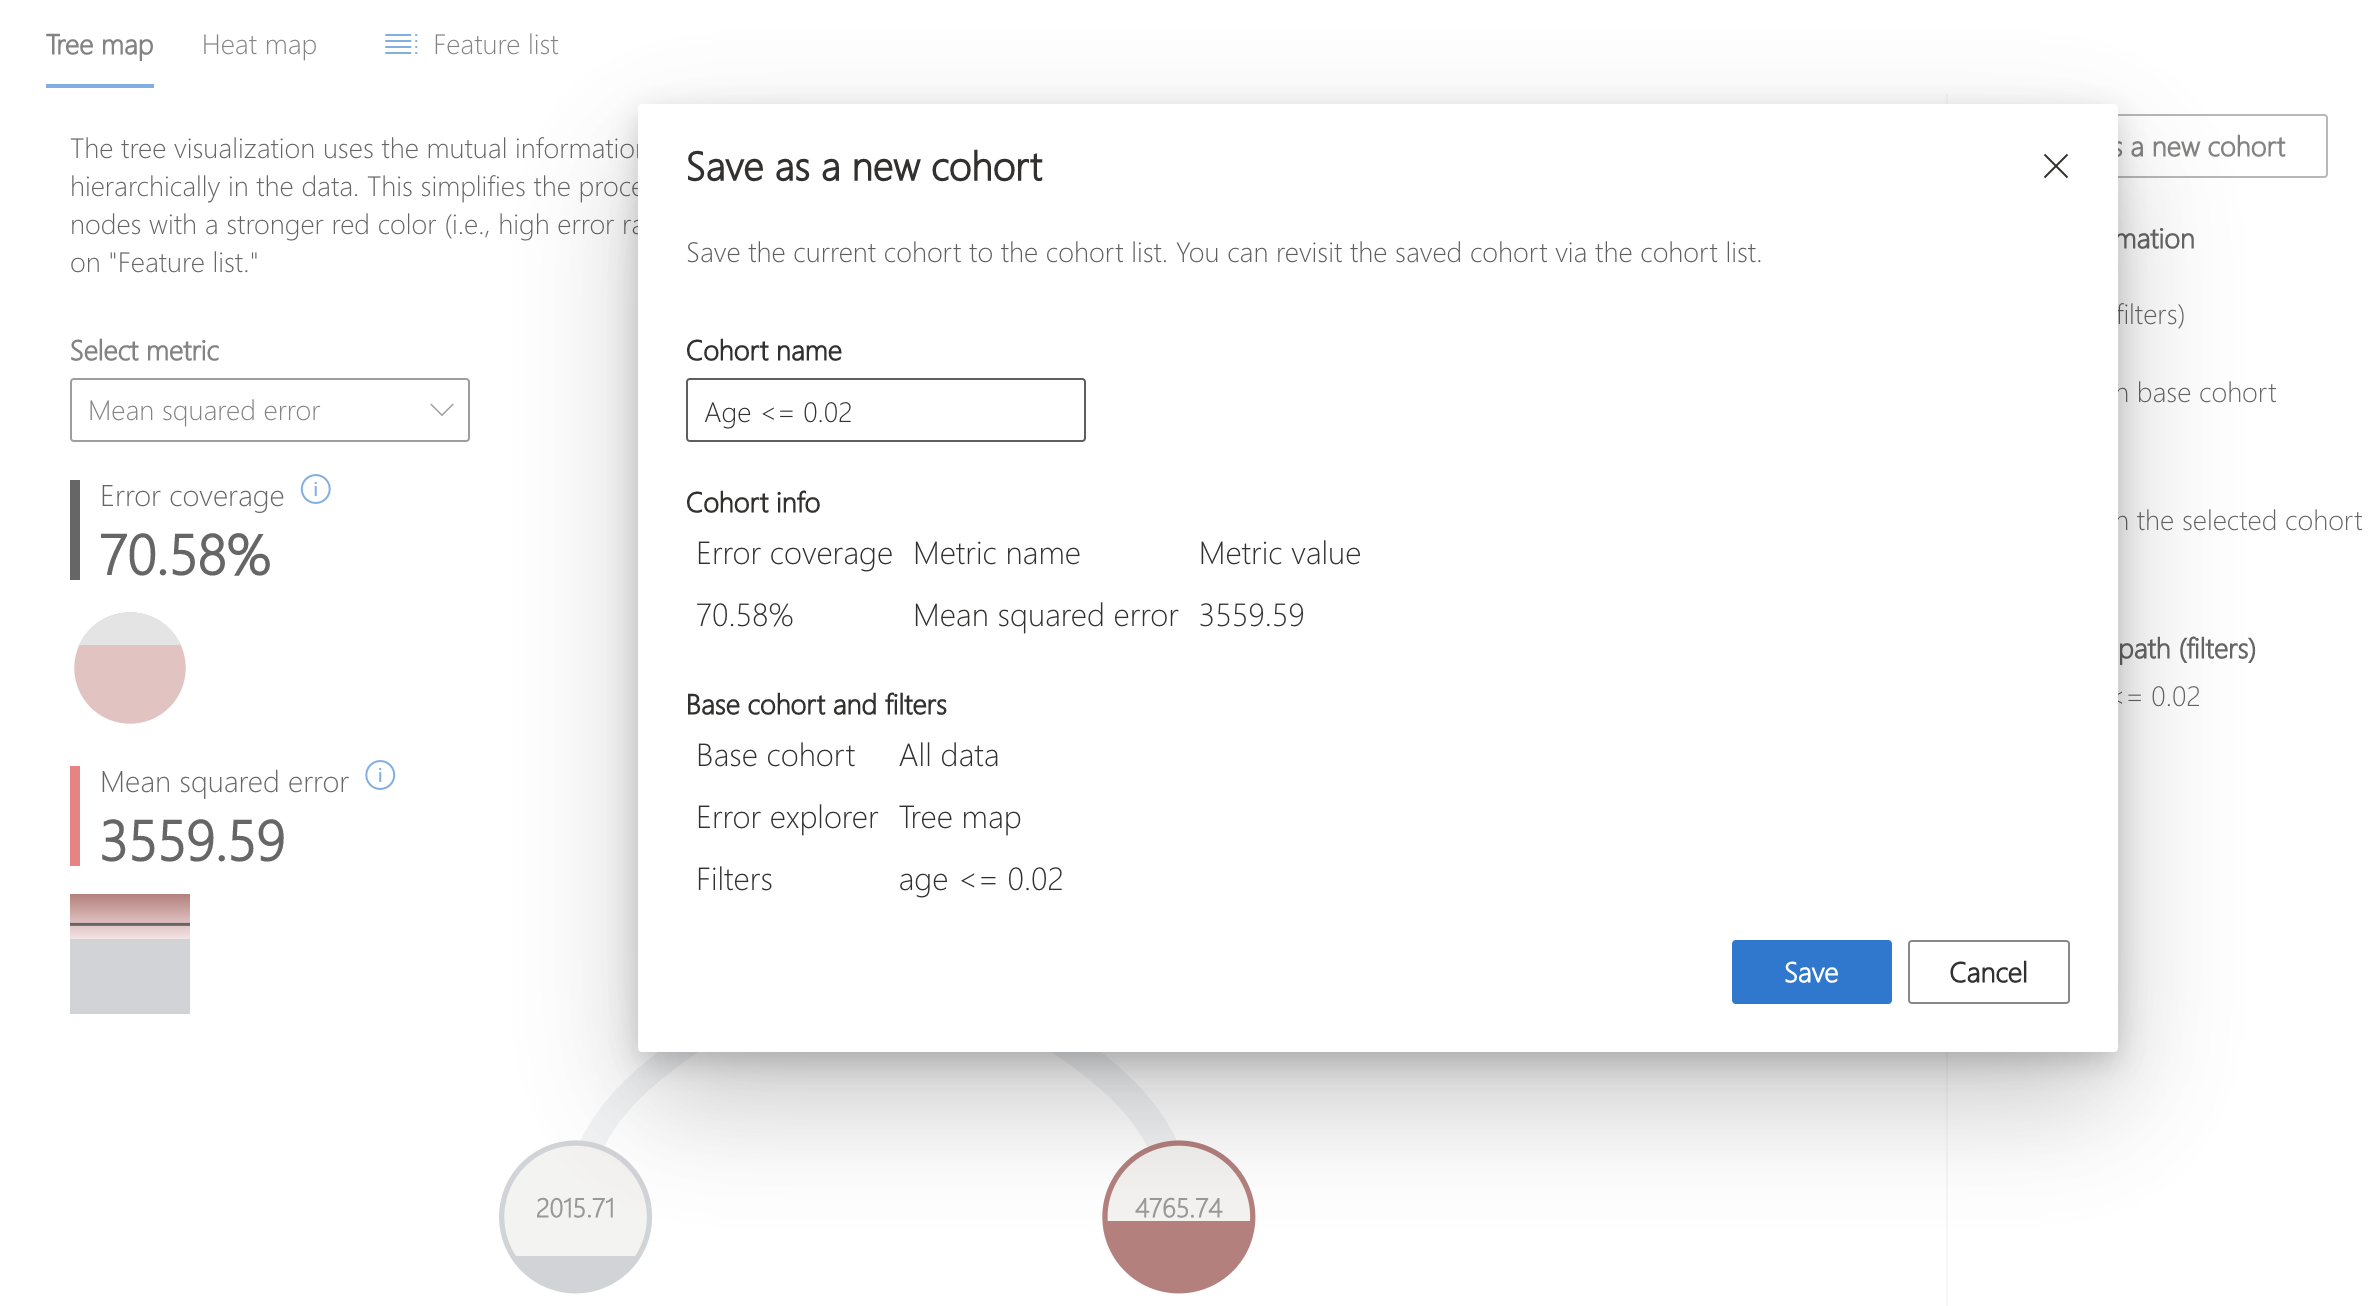

A continuación, haz clic en "Switch global cohort" y selecciona la cohorte guardada recientemente para centrar el análisis.

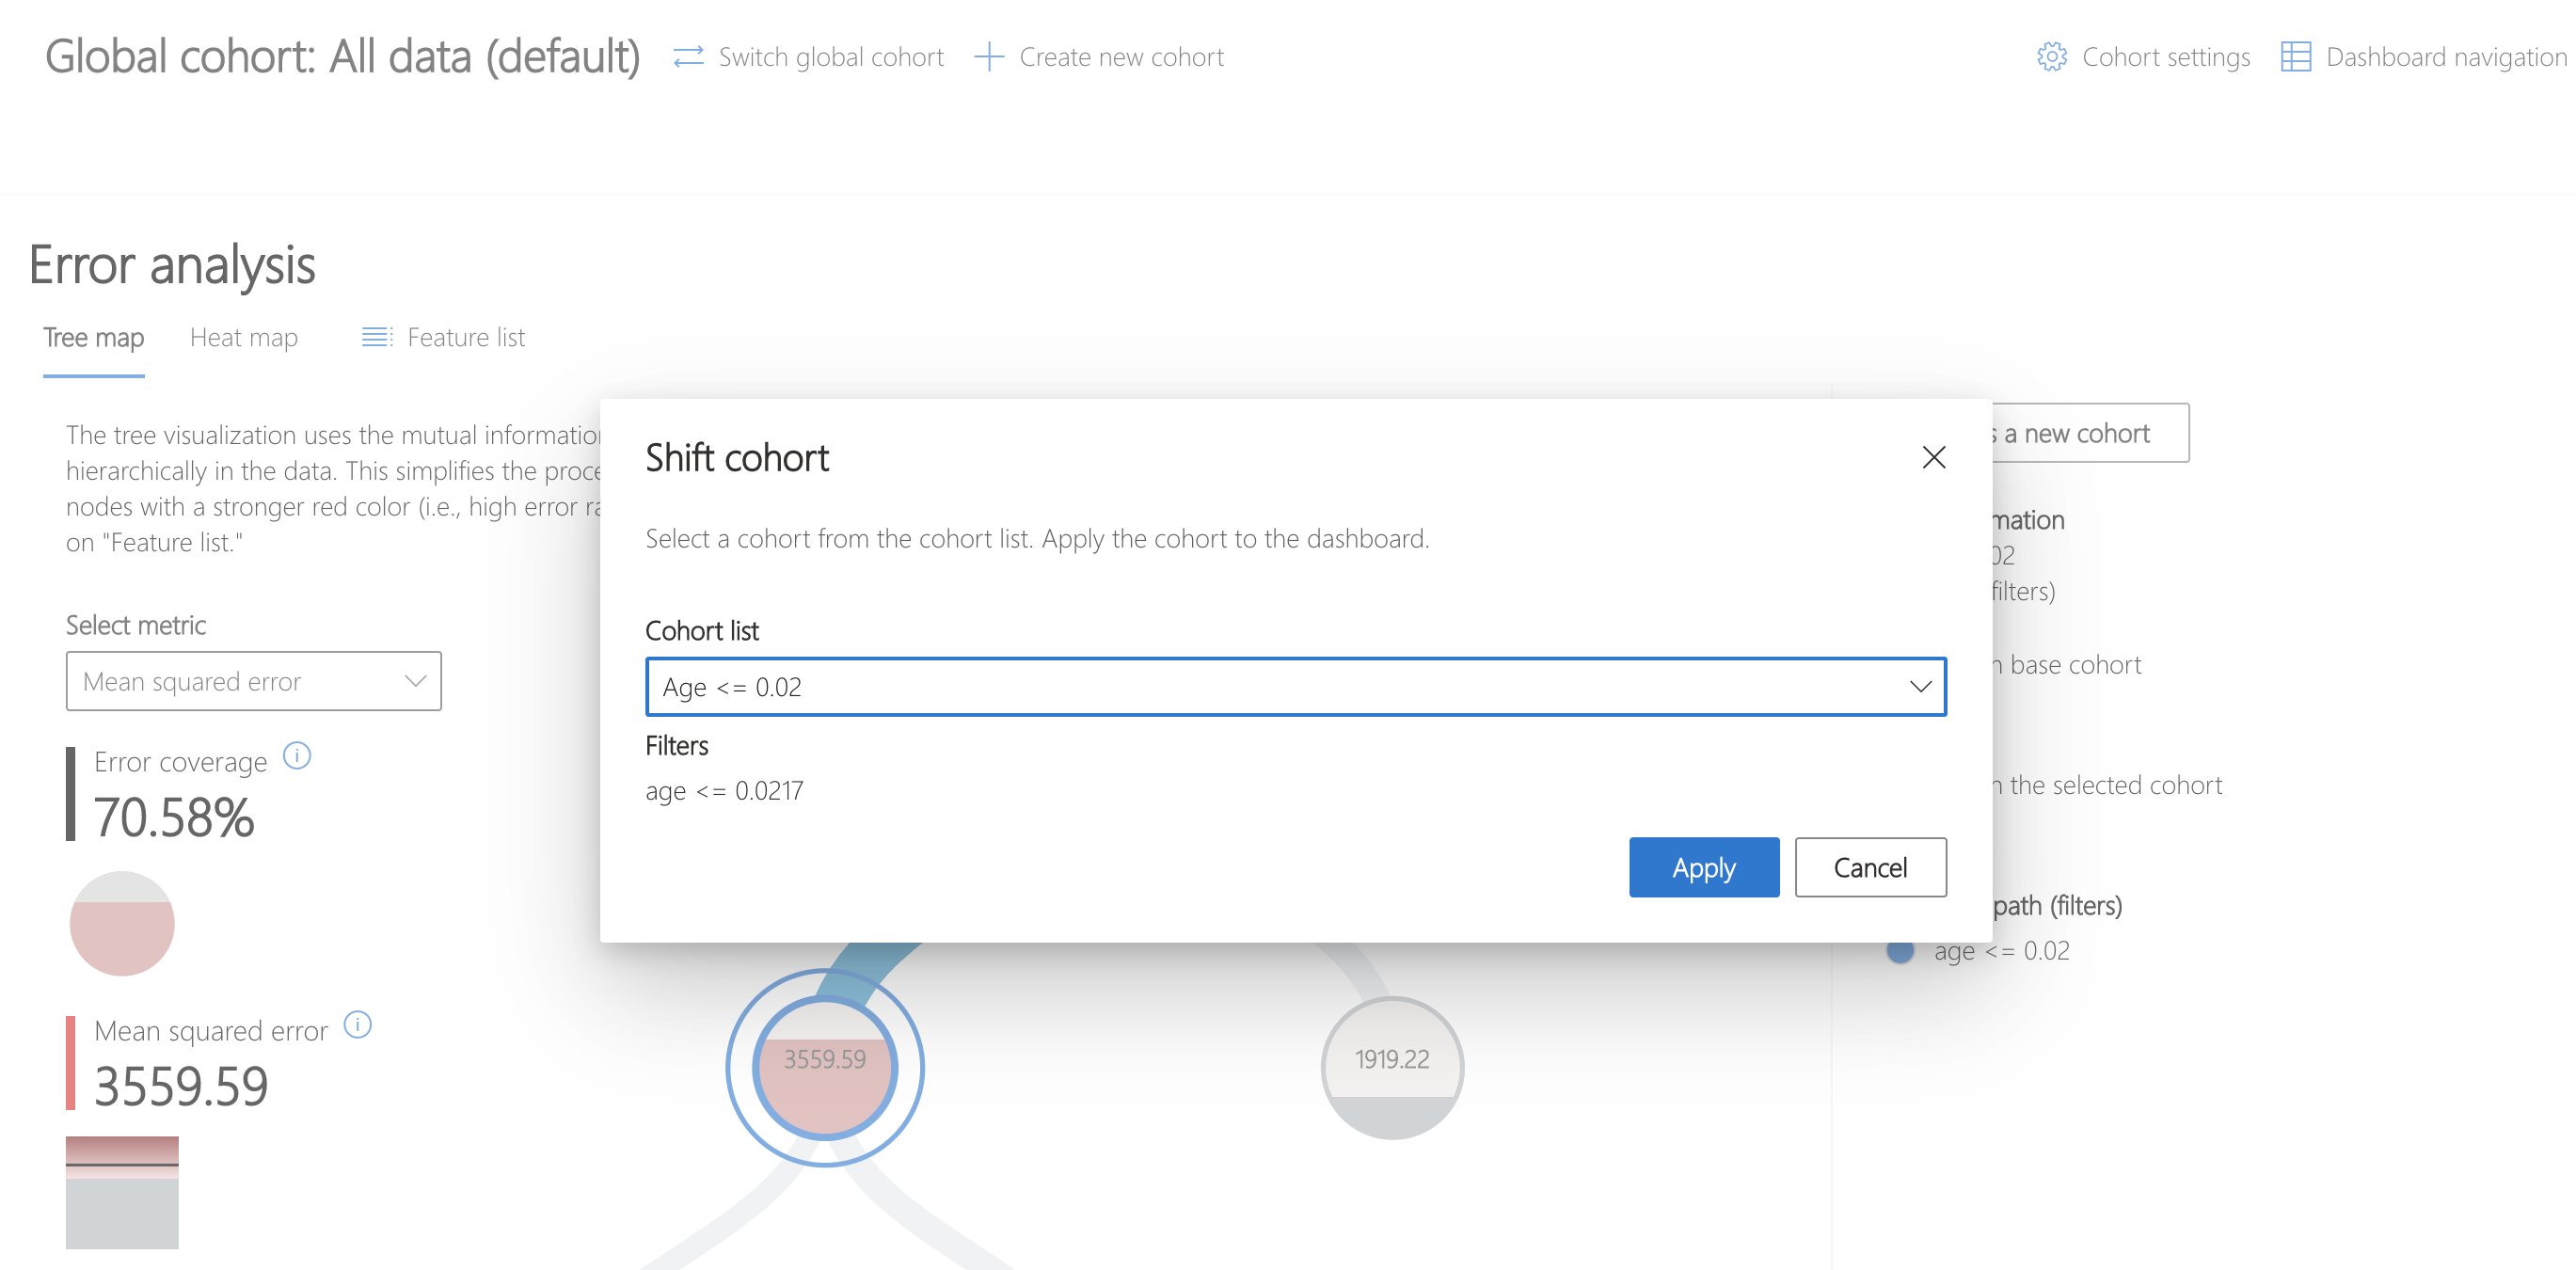

El mapa de calor se puede utilizar para comprender mejor esta cohorte visualizando las tasas de error de las subcohortes. La característica de investigación `s5`, [que se cree que representa el logaritmo del nivel de triglicéridos séricos]( https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes) que muestra una marcada diferencia en las tasas de error entre los intervalos de datos.

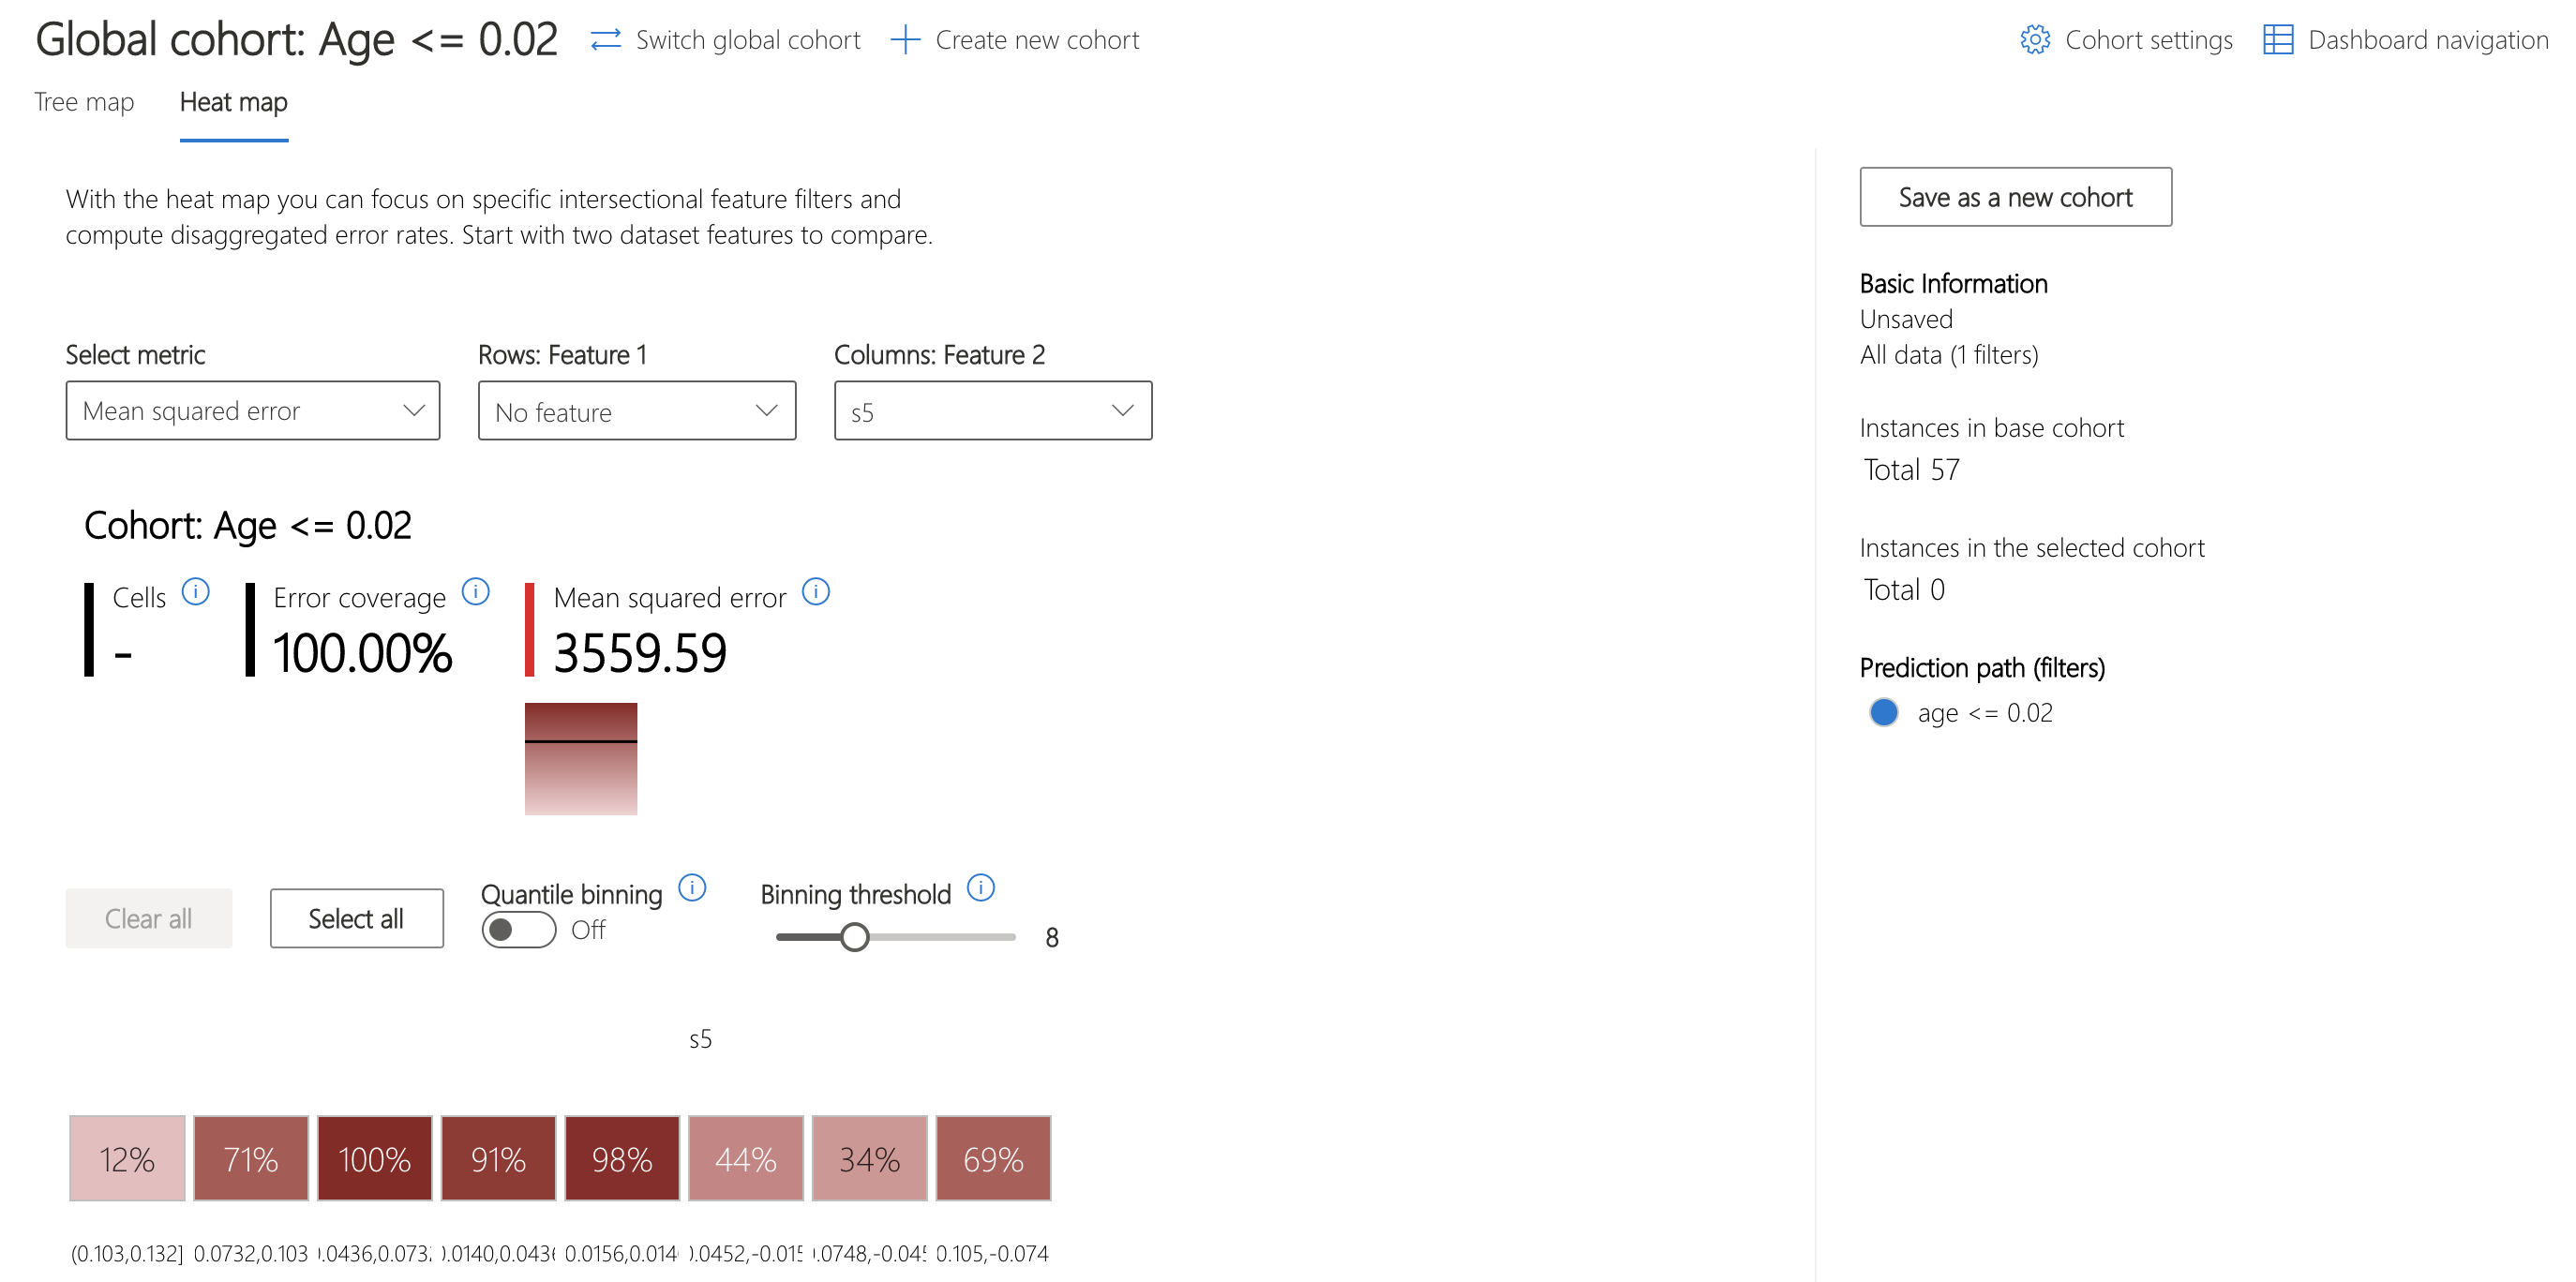

Usemos el componente Descripción general del modelo para examinar cómo se compara la distribución del error en el conjunto de datos general, estratificado por `s5`.

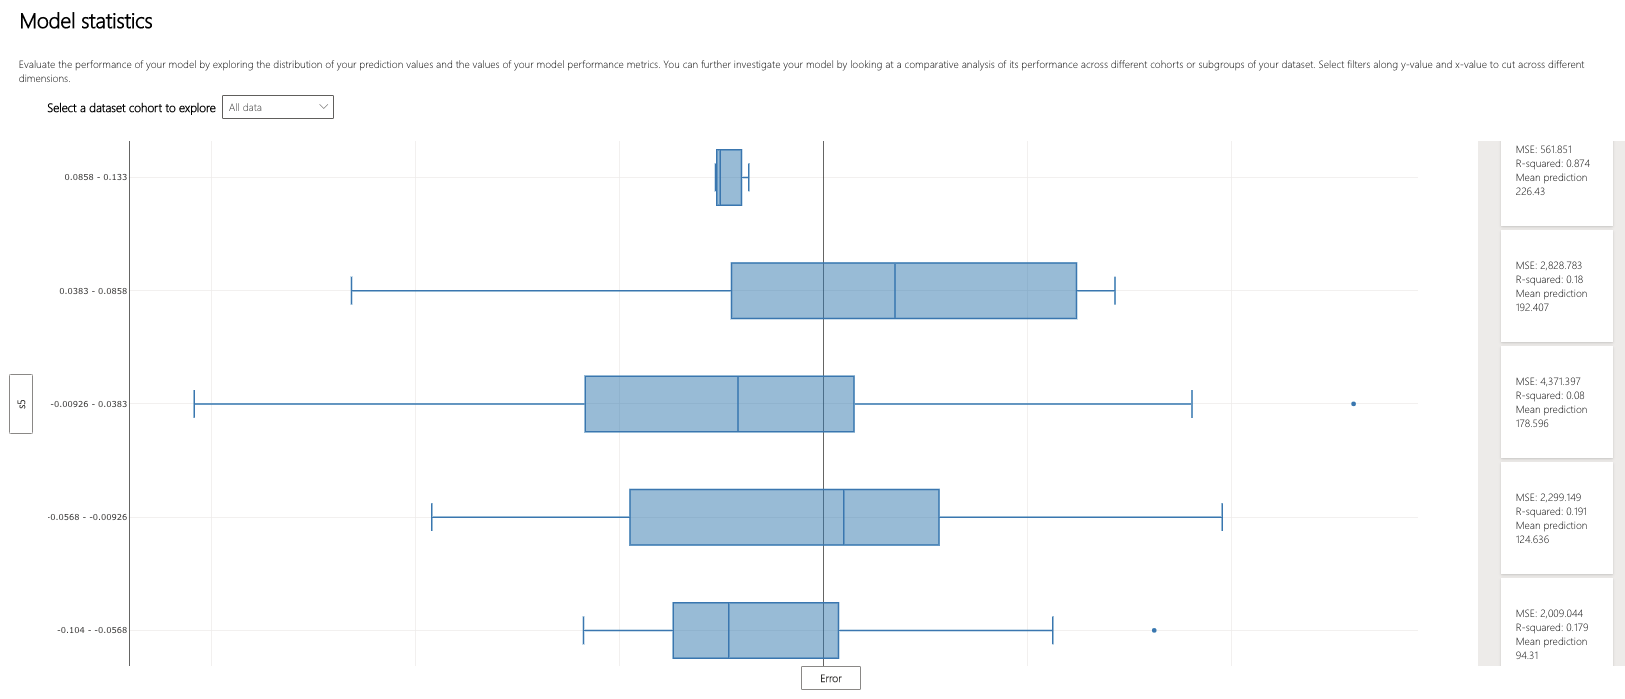

Parece que los tres bins centrales de los cinco tienen los mayores rangos de error intercuartílicos. ¿Cómo podrían relacionarse los patrones de error con la distribución subyacente de los datos?

El componente Explorador de datos puede ayudar a visualizar cómo se distribuyen los datos en estos bins. Curiosamente, los bins con el error más variado también tienen la mayor cantidad de puntos de datos. Intuitivamente, tiene sentido que cuantos más puntos haya en el contenedor, mayor será la variación de error dentro de él.

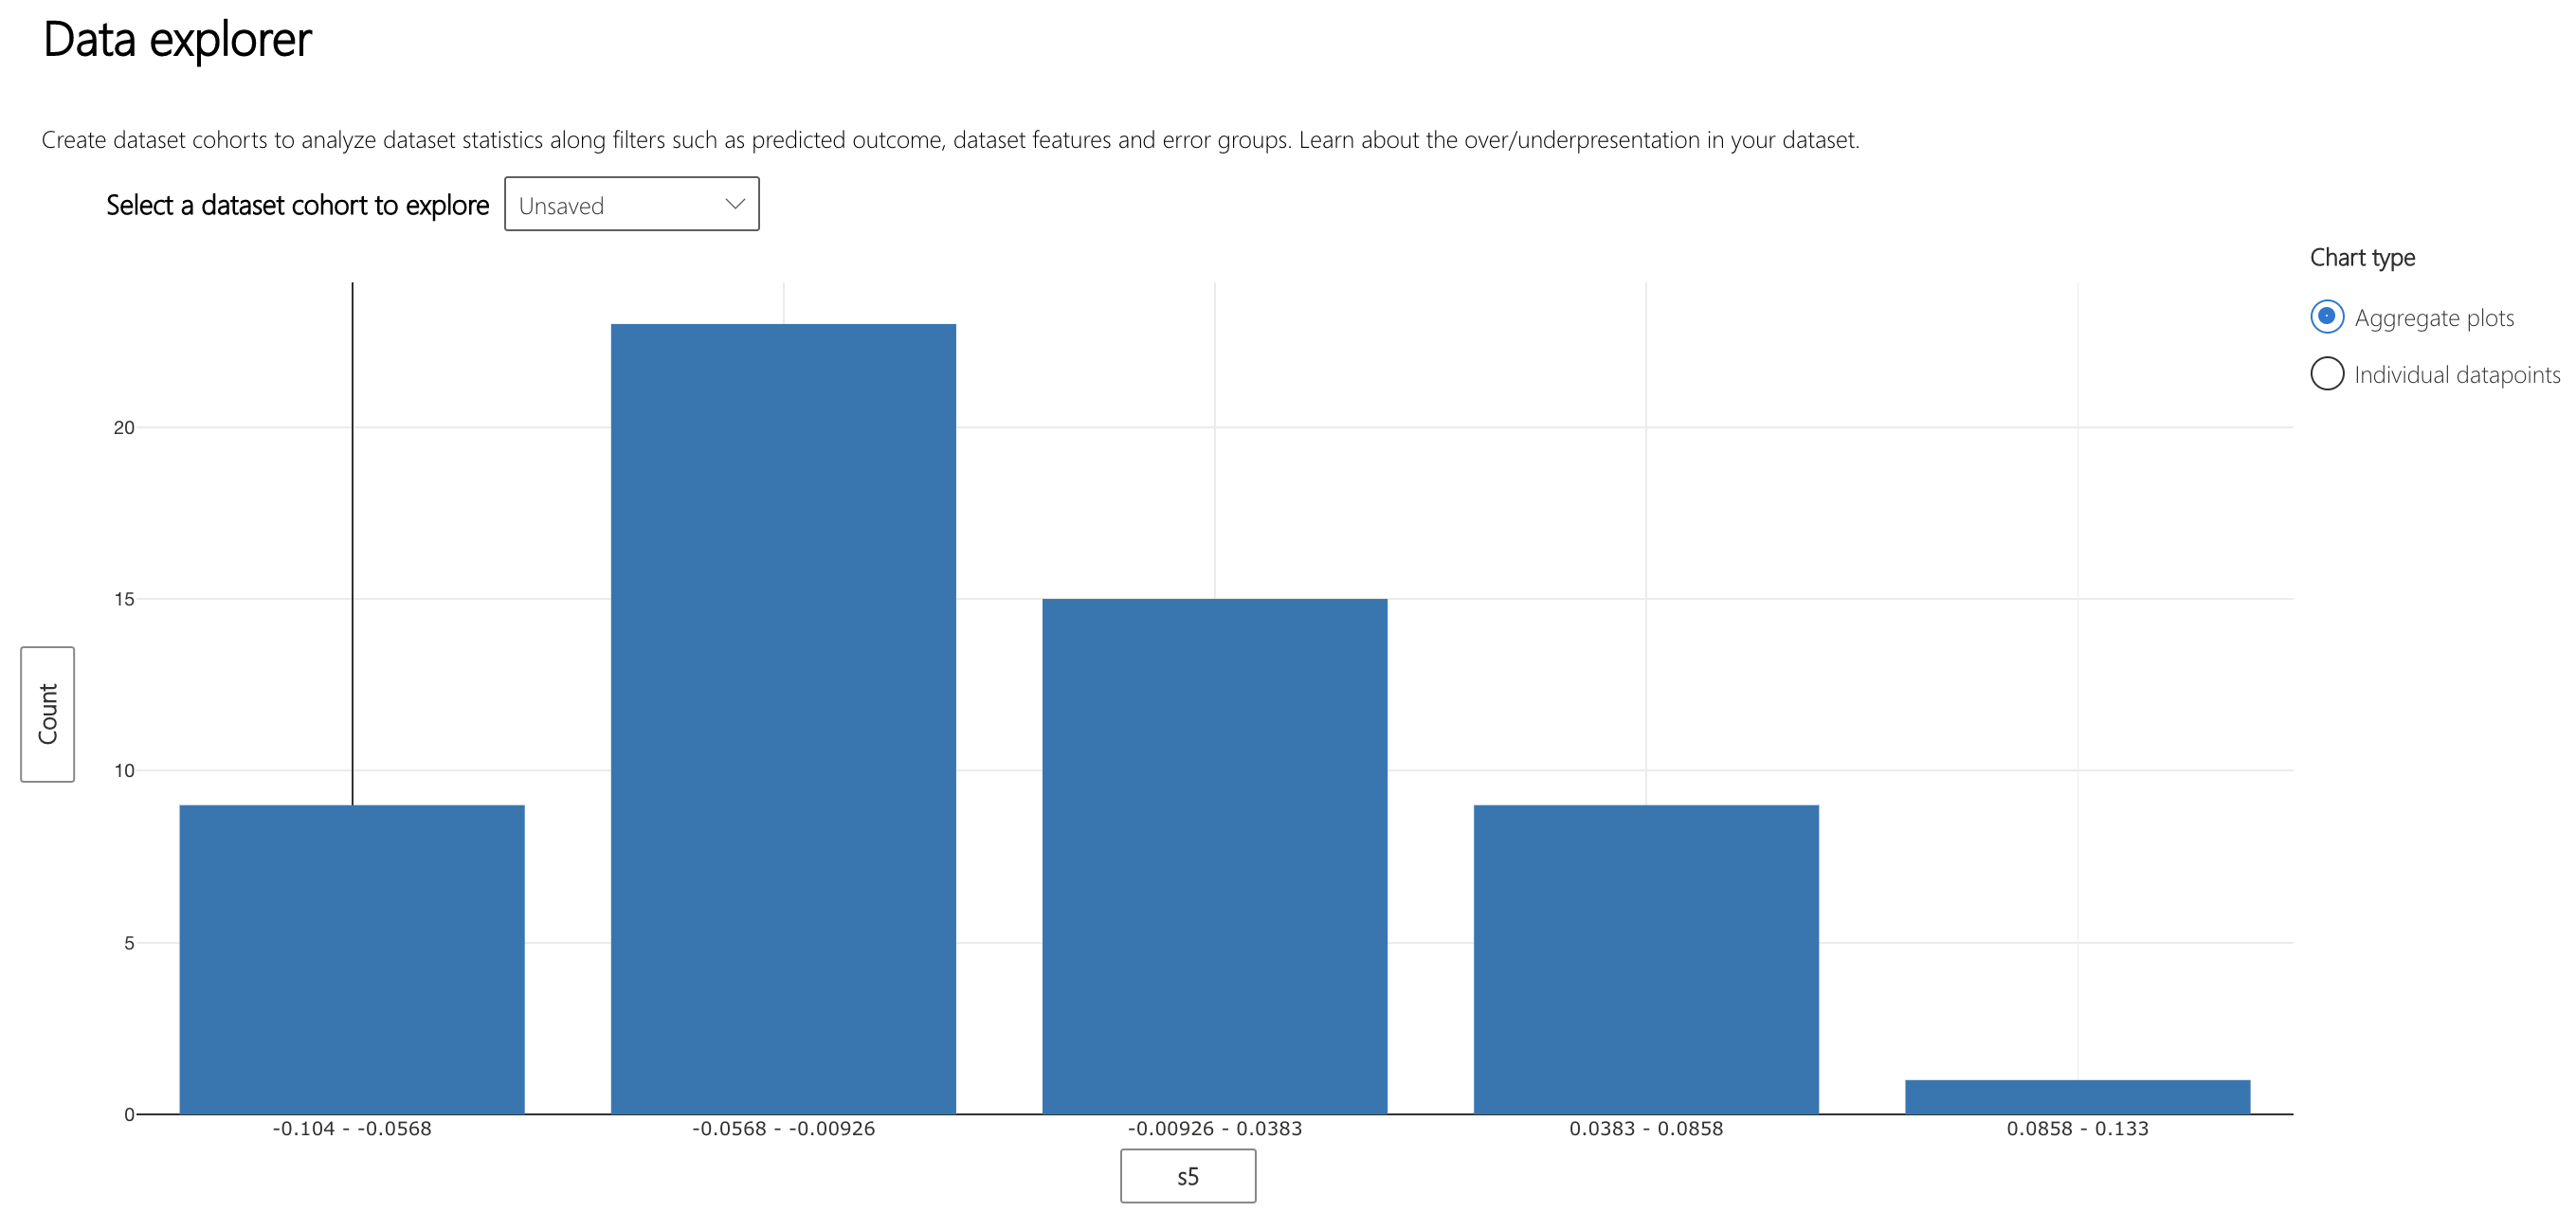

Pasando a comprender cómo el modelo toma decisiones, el gráfico "Importancia de la característica agregada" en el componente Interpretabilidad enumera las características principales utilizadas en todos los puntos de datos para realizar predicciones.

El `s5` y el `bmi`, el índice de masa corporal, son las características que más influyen en las decisiones de la modelo.

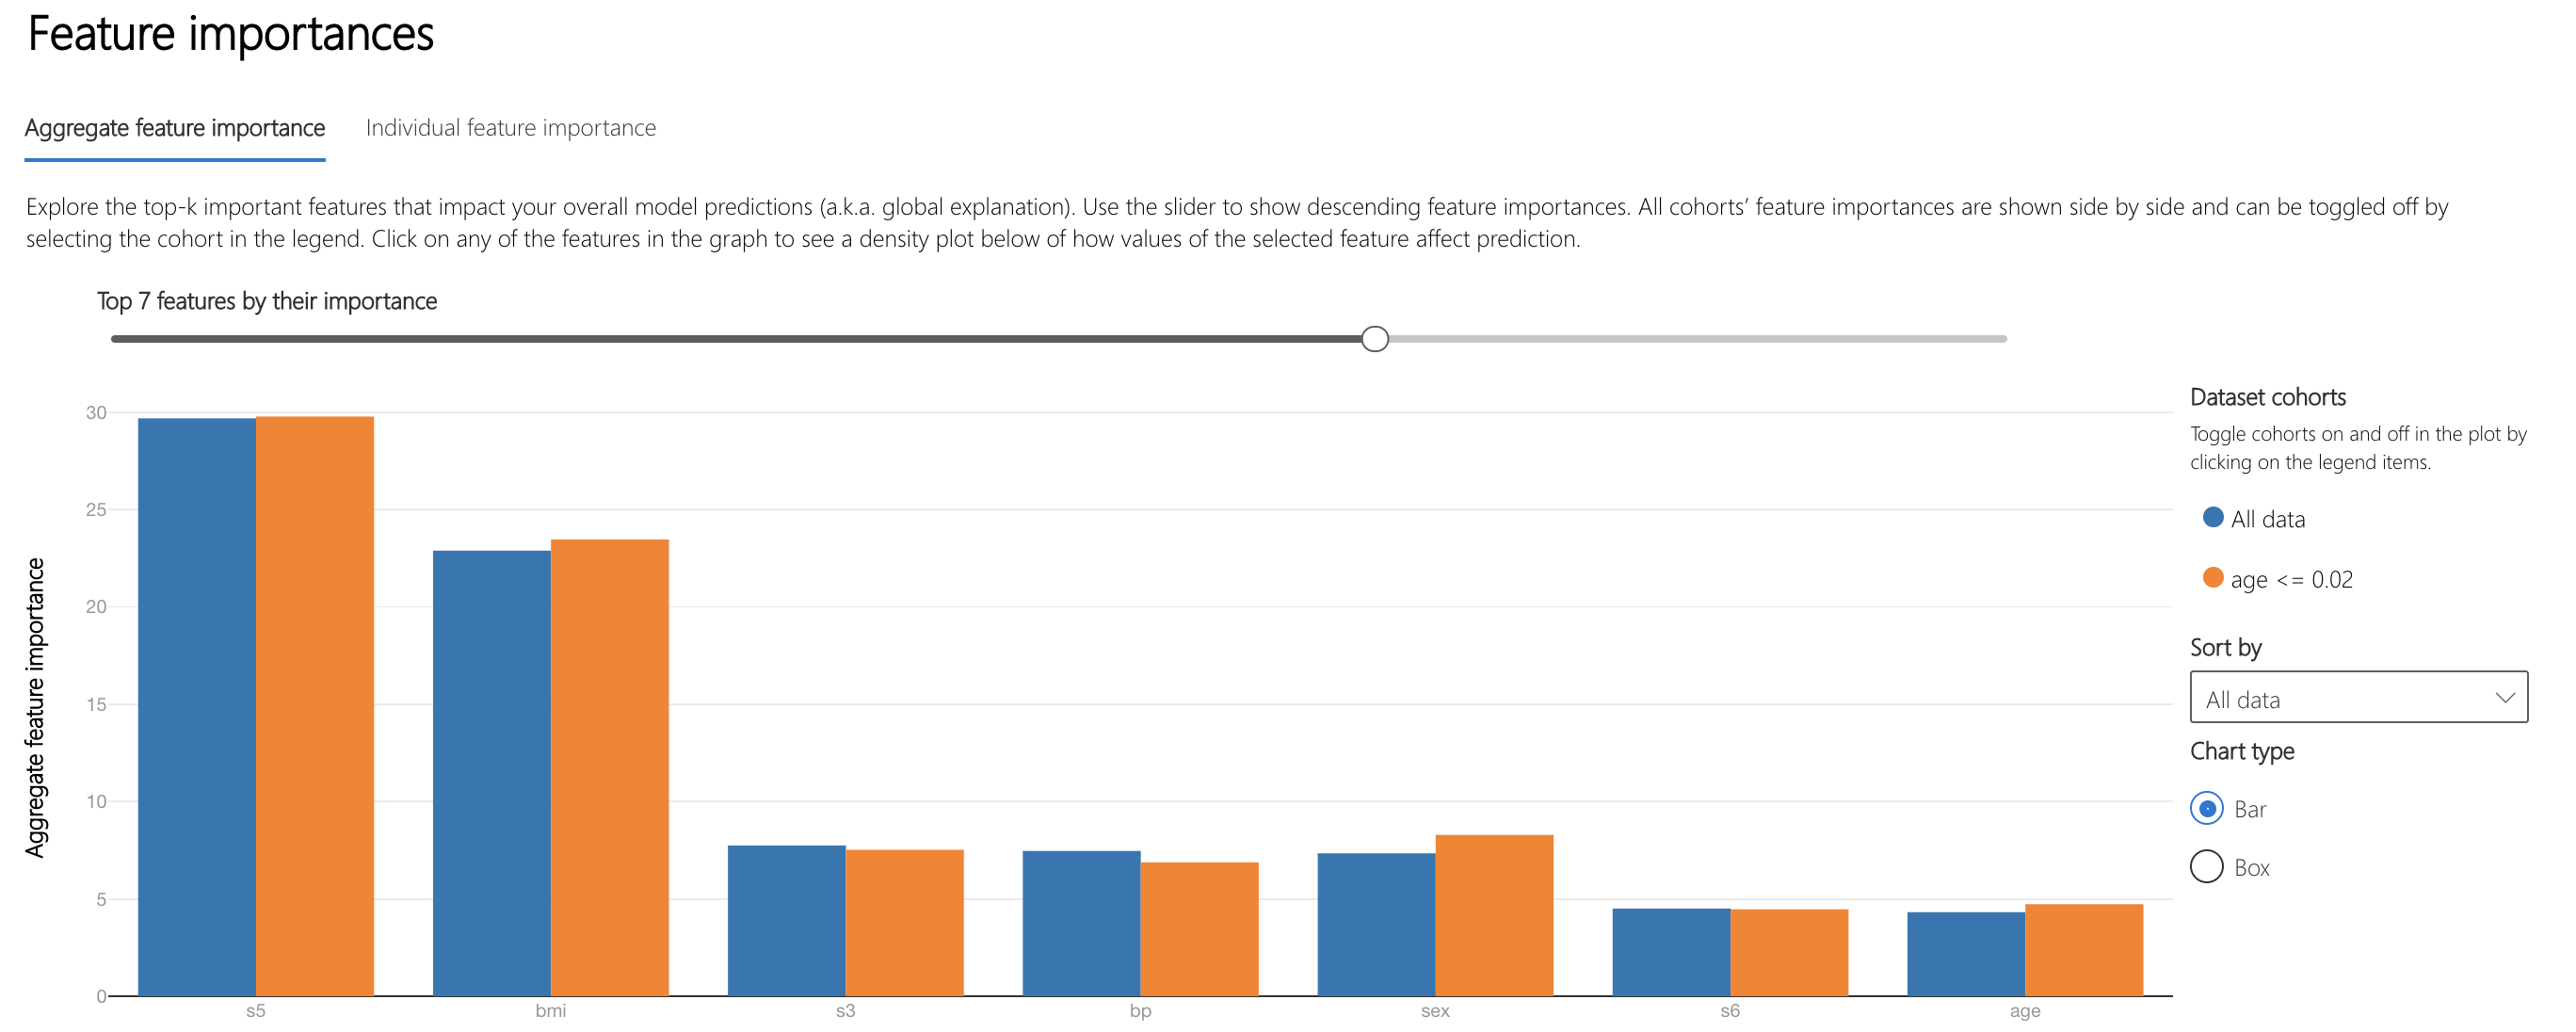

### Análisis Individual

La vista del componente Explorador de datos se puede modificar para mostrar un diagrama de dispersión de varias métricas en puntos de datos individuales. Aquí, vemos que la predicción con la mayor tasa de error de magnitud negativa pertenece al paciente 13.

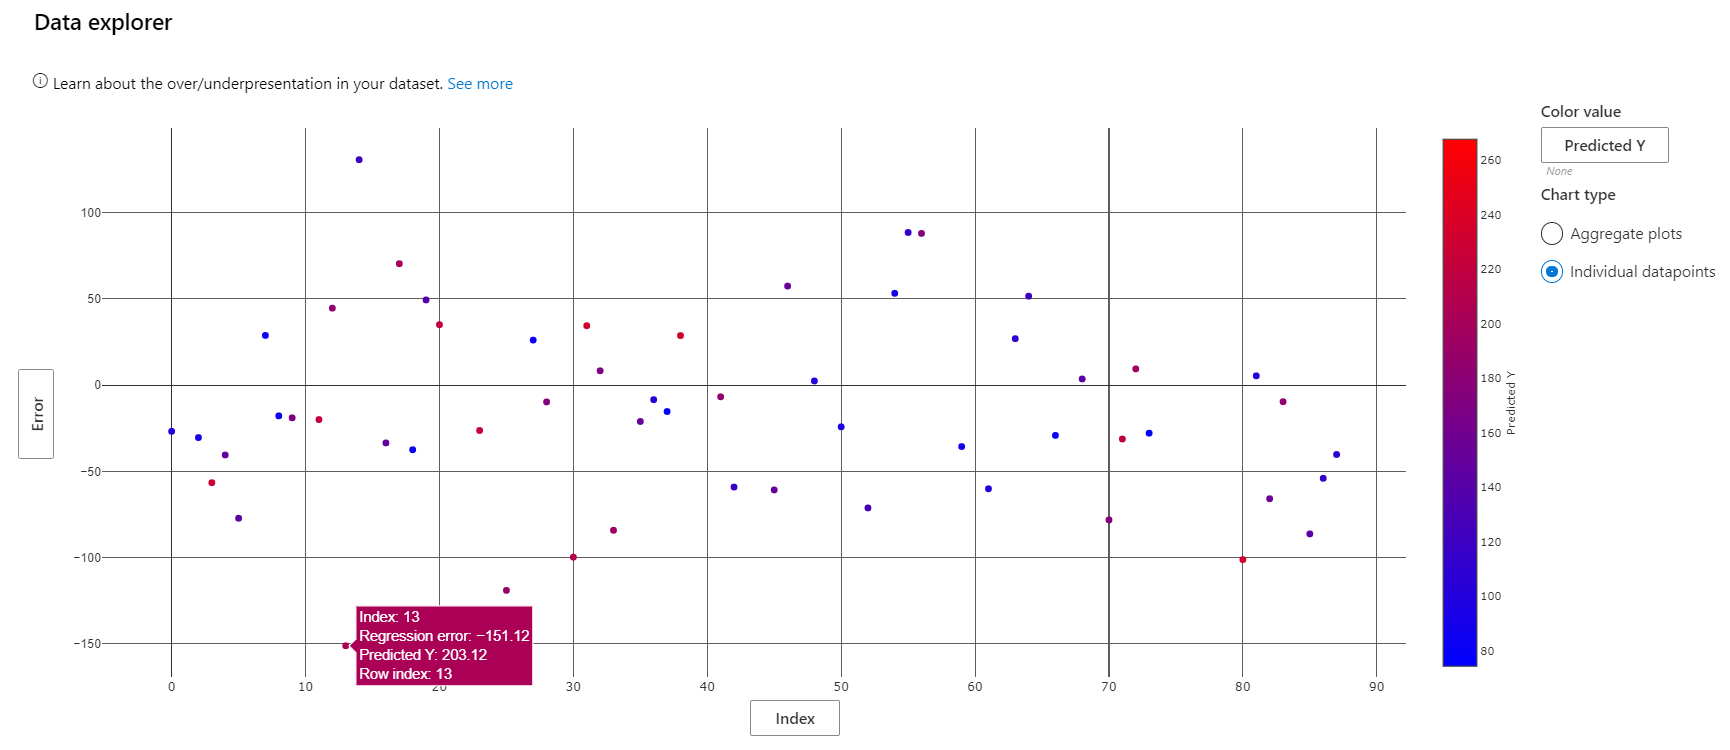

La puntuación real de progresión de la diabetes del paciente 13 es de 52, apenas una cuarta parte de la predicción del modelo. ¿Cómo salió tan mal el modelo? Utilice la "Importancia de la característica individual" para seleccionar el punto de datos correspondiente a este paciente para su posterior análisis.

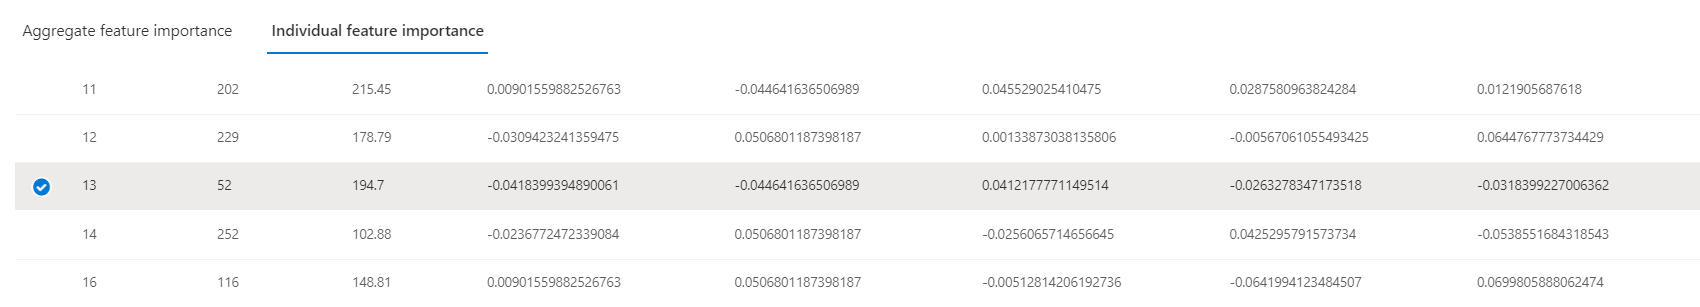

Desplazándonos hacia abajo, podemos ver que la predicción del modelo dependía más de s5, al igual que la importancia promedio de las características vista anteriormente.

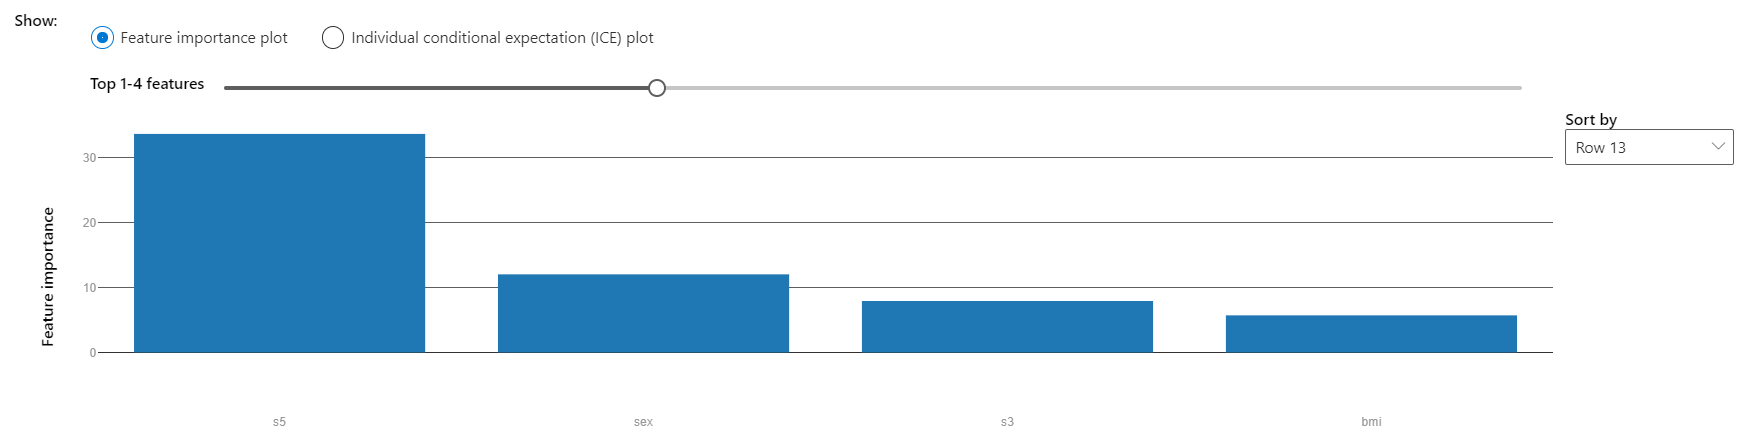

¿Cómo cambiaría la predicción del modelo si el valor `s5` de este punto de datos difiriera? Hay dos maneras de explorar la respuesta a esta pregunta.

La "Expectativa condicional individual", o gráfico ICE, ilustra cómo la predicción del modelo para este punto habría cambiado a lo largo de un rango de valores `s5`. El valor `s5` del punto es aproximadamente 0,03. Esta visualización muestra que un valor inferior de `s5` daría lugar a una disminución significativa en la predicción del modelo.

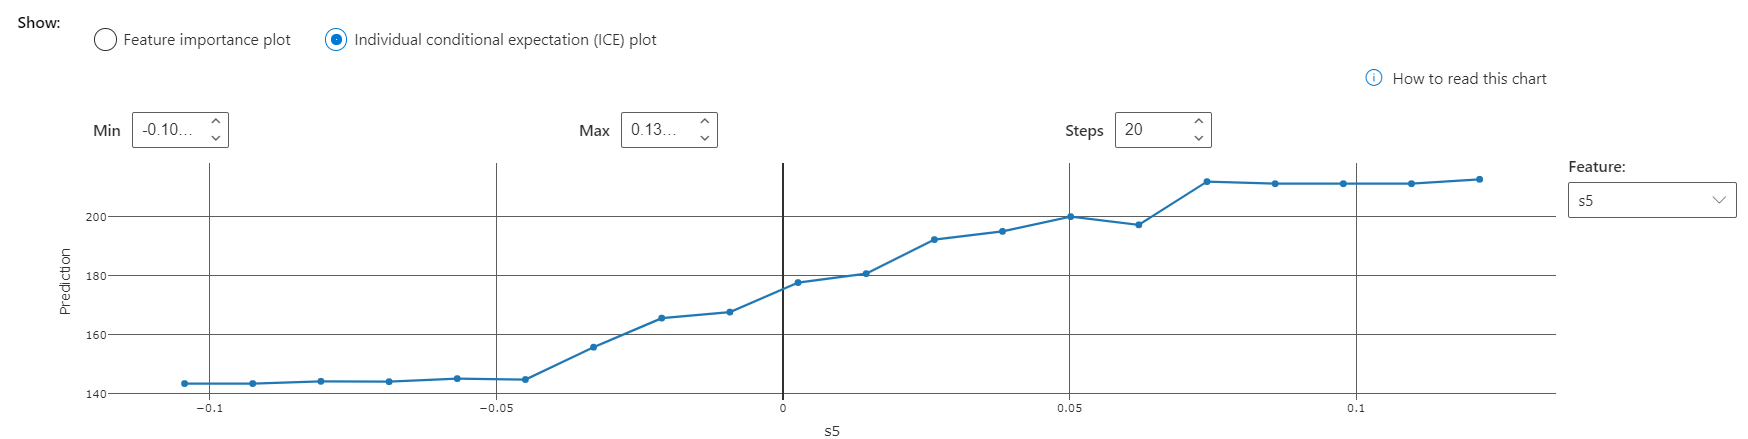

Un análisis similar se puede realizar en otro lugar. El componente Contrafactuales hipotéticos se utiliza para generar puntos artificiales similares a un punto real en el dataset, con los valores de una o algunas entidades establecidas de forma ligeramente diferente. Esto se puede utilizar para comprender cómo las diferentes combinaciones de características crean diferentes salidas de modelo.

El gráfico de características mejor clasificadas de este componente ilustra qué cambios en los valores de las características serían más efectivos para mover la predicción del modelo para el paciente 13 al rango especificado al agregar el componente contrafactual al panel (consulte el código anterior).

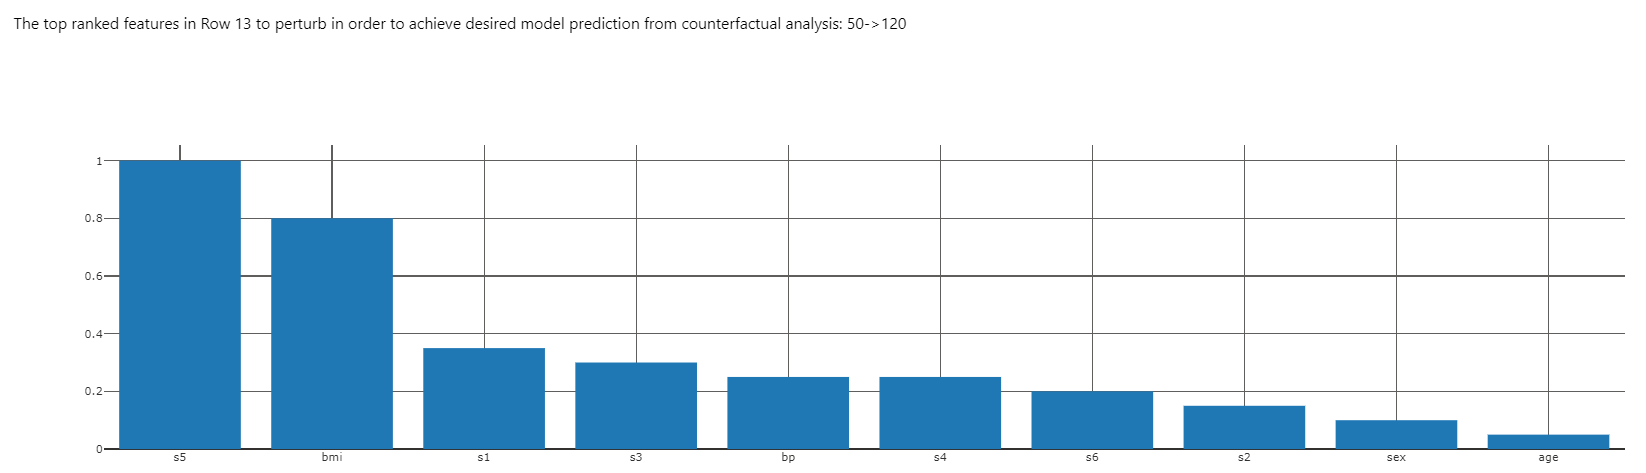

A partir del gráfico ICE, sabemos que la disminución de `s5` también disminuirá la predicción del modelo. Veamos cómo cambiar `s5` y `bmi` juntos cambiará la predicción. 

Seleccione el punto 13 en el diagrama de dispersión Contrafactuales hipotéticos y haga clic en "Create what-if counterfactual" a la derecha del diagrama de dispersión. Esto abre un panel lateral con contrafactuales de muestra y una opción para crear uno nuevo.

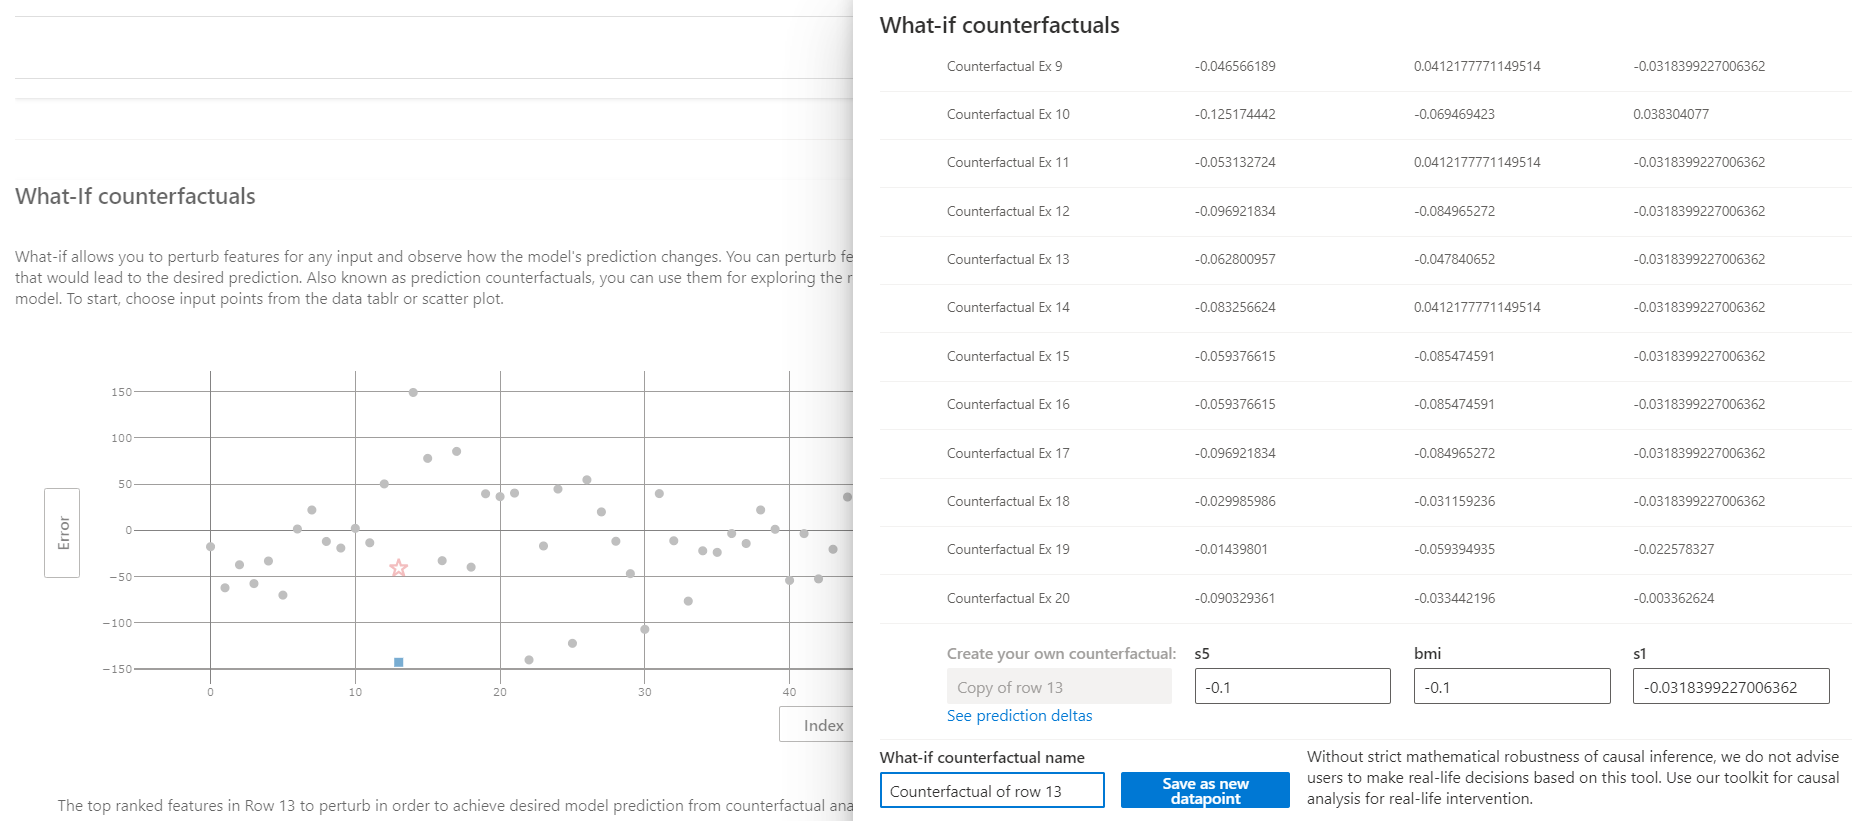

La creación de un contrafactual hipotético del punto 13 con el valor -0,1 para `s5` y `bmi` tiene el siguiente resultado. Vemos que la magnitud del error cae de aproximadamente 150 a aproximadamente 50.

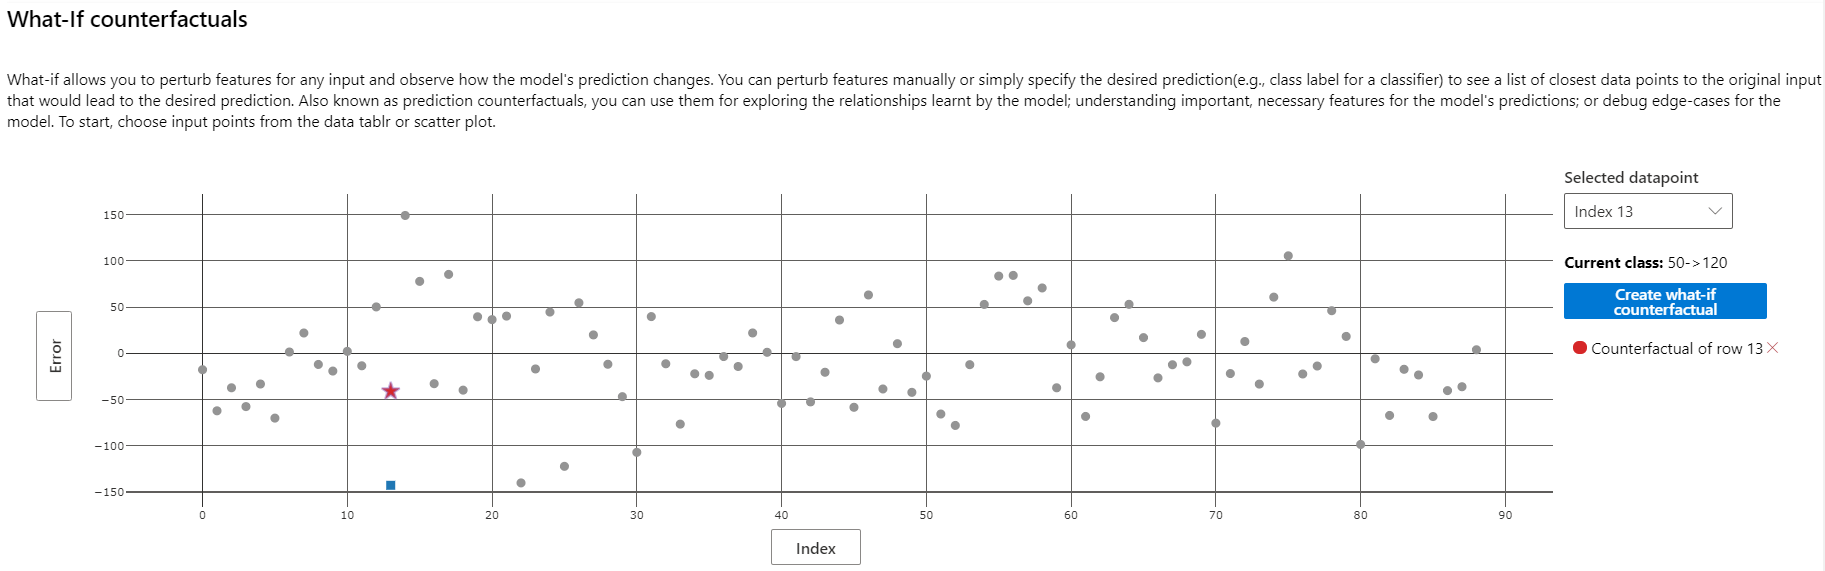